# imports

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import itertools
import matplotlib.pyplot as plt
from mif import MIF

# import math
# from IPython.core.display import display, HTML #this is just for display
# display(HTML("<style>.container { width:100% !important; }</style>")) #this is just for display

# setup env

In [2]:
# Network Architecture
num_inputs = 28*28
num_hidden = 500
num_outputs = 10

# Training Parameters
batch_size=1
data_path='/data/mnist'

# Temporal Dynamics
num_steps = 1000

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# dl dataset

In [3]:
# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

# Create DataLoaders
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

# def network

In [10]:
# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_outputs)
        self.mif1 = MIF()
        # self.fc2 = nn.Linear(num_hidden, num_outputs)
        # self.mif2 = mif.MIF()

    def forward(self, x):

        # Initialize hidden states and outputs at t=0
        x1, x2, G1, G2, a, I, v = self.mif1.init_MIF(batch_size, num_outputs)       

        # Record the final layer
        v_rec = []
        I_rec = []

        for step in range(num_steps):
            x1, x2, G1, G2, a, I, v = self.mif1(self.fc1(x), x1, x2, G1, G2, a, I, v)

            v_rec.append(v)
            I_rec.append(I)

        return torch.stack(v_rec, dim=0), torch.stack(I_rec, dim=0)

# accuracy measure

In [11]:
def print_batch_accuracy(data, targets, train=False):
    v_rec, _ = net(data.view(batch_size, -1)) # T x B x 10
    t_max, _ = v_rec.max(dim=0) # find max for each time-dim
    _, idx = t_max.max(dim=-1) # find max for each neuron index
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train Set Accuracy: {acc}")
    else:
        print(f"Test Set Accuracy: {acc}")

def train_printer():
    print(f"Epoch {epoch}, Minibatch {minibatch_counter}")
    print(f"Train Set Loss: {loss_hist[counter]}")
    print(f"Test Set Loss: {test_loss_hist[counter]}")
    print_batch_accuracy(data_it, targets_it, train=True)
    print_batch_accuracy(testdata_it, testtargets_it, train=False)
    print("\n")

# training loop

In [12]:
net = Net().to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=2e-4, betas=(0.9, 0.999))
log_softmax_fn = nn.LogSoftmax(dim=-1)
loss_fn = nn.NLLLoss()

loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(3):
    minibatch_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data_it, targets_it in train_batch:
        data_it = data_it.to(device)
        targets_it = targets_it.to(device)

        v_rec, I_rec = net(data_it.view(batch_size, -1))
        log_p_y = log_softmax_fn(v_rec)
        loss_val = torch.zeros((1), dtype=dtype, device=device)

        # Sum loss over time steps: BPTT
        for step in range(num_steps):
          loss_val += loss_fn(log_p_y[step], targets_it)

        # Gradient calculation
        optimizer.zero_grad()
        loss_val.backward()

        # Weight Update
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        test_data = itertools.cycle(test_loader)
        testdata_it, testtargets_it = next(test_data)
        testdata_it = testdata_it.to(device)
        testtargets_it = testtargets_it.to(device)

        # Test set forward pass
        test_v, test_I = net(testdata_it.view(batch_size, -1))

        # Test set loss
        log_p_ytest = log_softmax_fn(test_v)
        log_p_ytest = log_p_ytest.sum(dim=0)
        loss_val_test = loss_fn(log_p_ytest, testtargets_it)
        test_loss_hist.append(loss_val_test.item())

        # Print test/train loss/accuracy
        if counter % 50 == 0:
            train_printer()
        minibatch_counter += 1
        counter += 1

loss_hist_true_grad = loss_hist
test_loss_hist_true_grad = test_loss_hist

Epoch 0, Minibatch 0
Train Set Loss: nan
Test Set Loss: nan
Train Set Accuracy: 0.0
Test Set Accuracy: 0.0


Epoch 0, Minibatch 50
Train Set Loss: nan
Test Set Loss: nan
Train Set Accuracy: 0.0
Test Set Accuracy: 0.0




KeyboardInterrupt: 

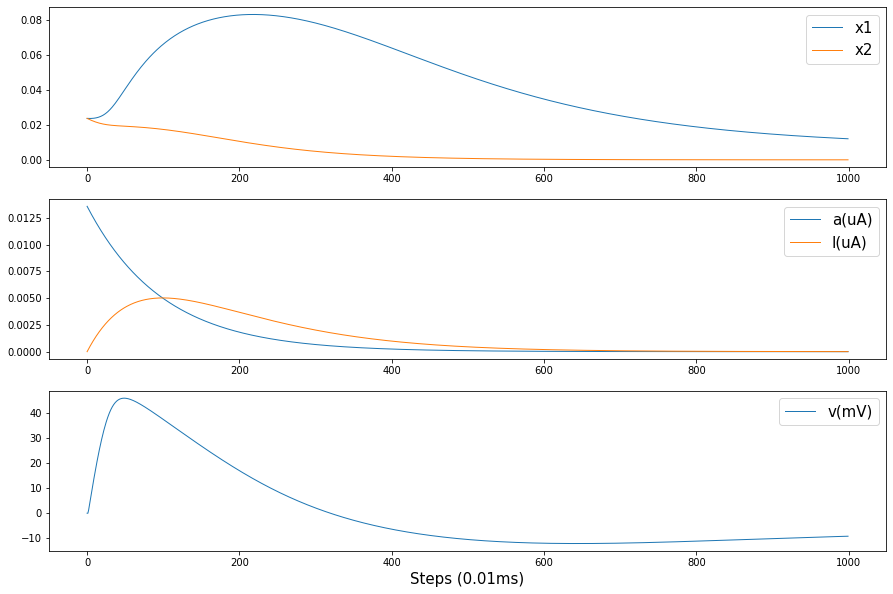

In [10]:
plt.figure(figsize=(15,10))
plt.subplot(311)
plt.plot(range(steps), x1, label='x1', lw = 1)
plt.plot(range(steps), x2, label='x2', lw = 1)
plt.legend(fontsize=15)
plt.subplot(312)
plt.plot(range(steps), a, label='a(uA)', lw = 1)
plt.plot(range(steps), I, label='I(uA)', lw = 1)
plt.legend(fontsize=15)
plt.subplot(313)
plt.plot(range(steps), v, label='v(mV)', lw = 1)
plt.xlabel('Steps (0.01ms)', fontsize=15)
plt.legend(fontsize=15)